<a href="https://colab.research.google.com/github/roklp/MLP34/blob/main/obesity_classifier_5c0934.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F68479%2F7609535%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240229%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240229T001502Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D010159ccdcab4a64175f0b659f0295f5932356f325042fa4bca67ea8e84974ccba58732fbe4a91c9795bf1fa6d321fcb705626c351b78eeba6c70cee5fb9be30645c6687c3cfb7f051666c193132fd1b1b5ece4c37ef24eaf8f3b39e2d23c97454f98820413bcf0eb941a50c8f7c0c7e6cf4f73ba9ad9f9edf2161df1a228d32a2a2a039955c900480b7d5e5739850bb297105845583a8b57ecd4e5d008ff543d11346f036963f18d153dd36374039371f8a7ed7a08db71d4f27b885a9e8a0e3885f16d699fb5fa14552769f62a84646942fab24abfb6dbfd6c8e241c405481fce7f290e69708af4db6957c05e93e25e540f47b4d66cd2d20c71b7c8bb6cb890'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 939479 bytes downloaded
Downloaded and uncompressed: playground-series-s4e2
Data source import complete.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Introduction
In this Notebook we show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost

In the pre-processing steps, we convert the non numerical features using the LabelEncoding for most of the columns, i.e.for
the columns that have only two possible values or more than two sortable values. The only column that has not these characteristic is the MTRANS, where we apply the one-hot encoding.

Then we do some data exploration, analyzing the correlation between numerical features and labels, the distribution of train and test data, the distribution of labels, etc...

Then we train 4 different baseline classifier: RandomForest, GradientBoosting, LightGBM and XGBoost, XGBoost shows the best performance, so we decide to optimize
its hyperparameters by using the framework Optuna.

Finally we perfrom the predictions in two ways:

 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5


## 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [4]:
# train 데이터를 불러 옴.
df = pd.read_csv('/content/drive/MyDrive/data/kaggle1/train.csv', index_col = 0)

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


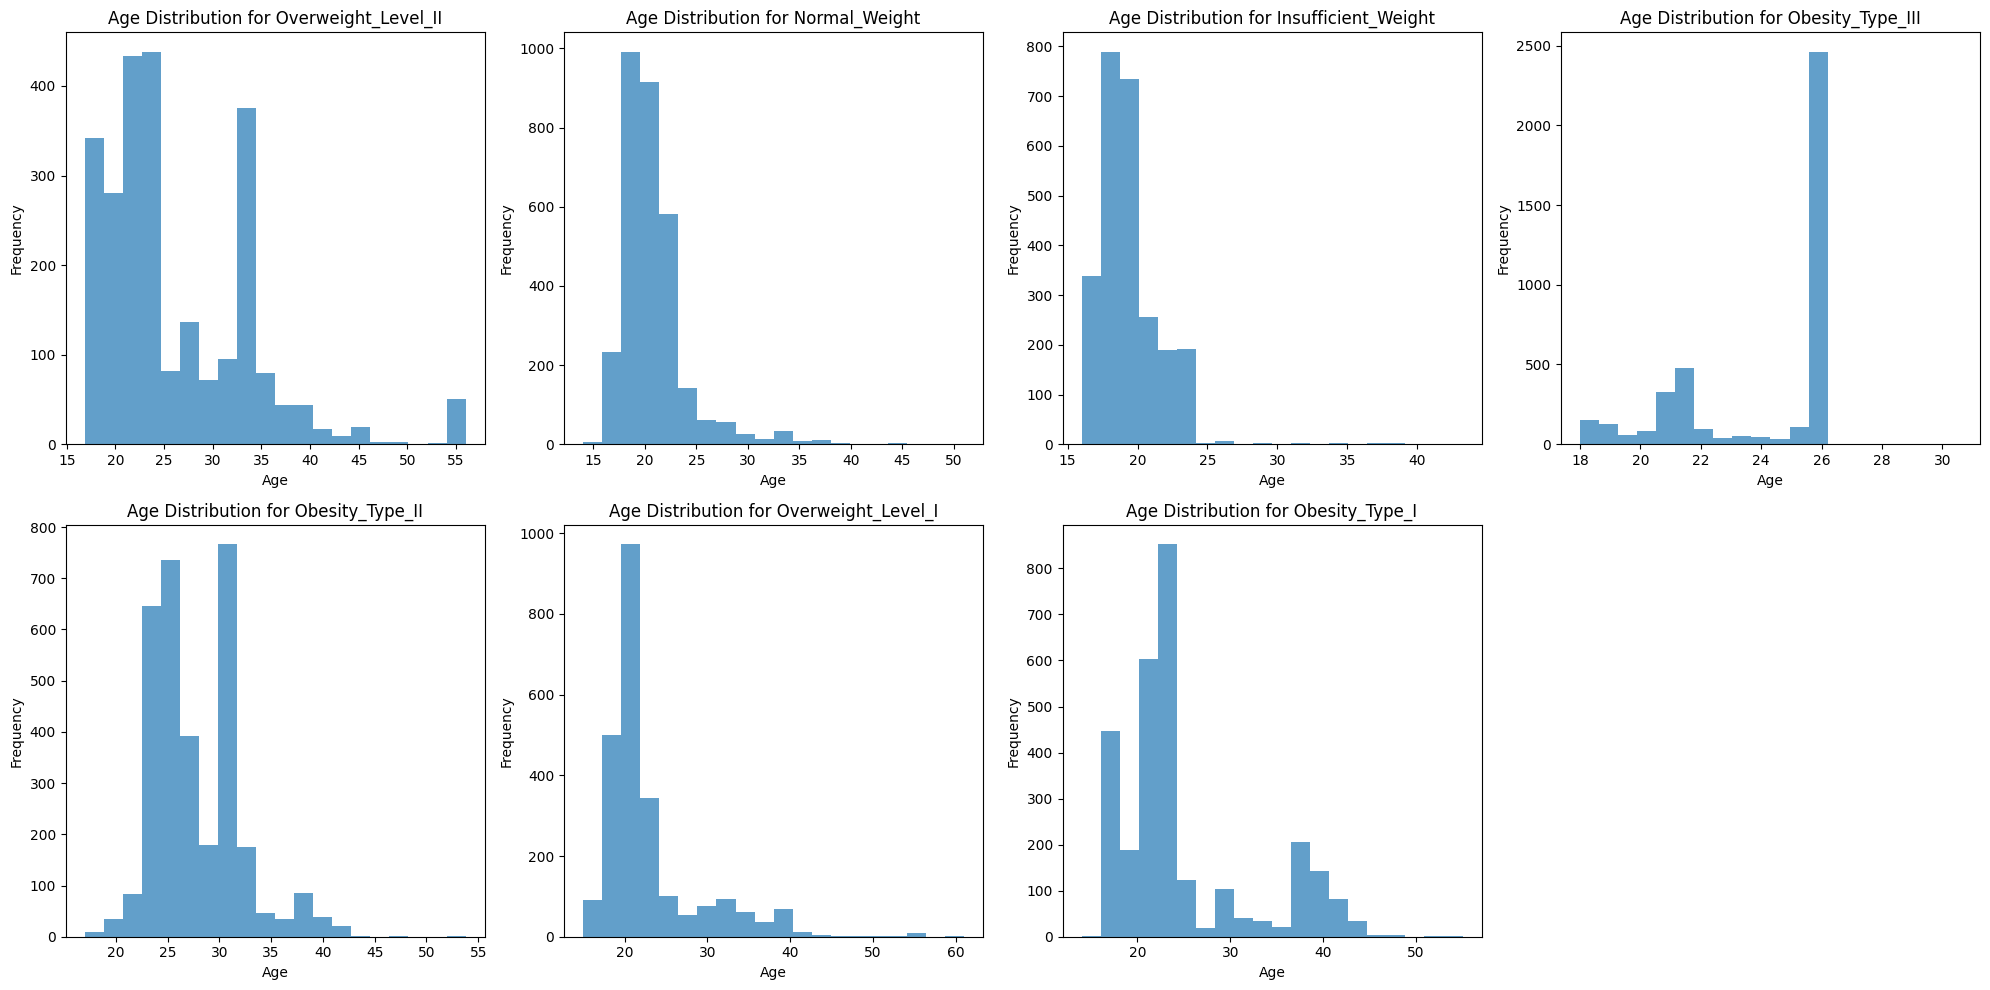

In [5]:
# 각 비만도 별로 나이 분포대 시각화
unique_categories = df['NObeyesdad'].unique()
print(unique_categories)
plt.figure(figsize=(20,10))

for i, category in enumerate(unique_categories, start=1):
    category_data = df[df['NObeyesdad'] == category]['Age']
    plt.subplot(2, 4, i)
    plt.hist(category_data, bins=20, alpha=0.7)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

# train_data 결측치 없음을 확인.
df.isnull().sum()

In particular we can deduct that:

- 'Gender', 'Age', 'Height', 'Weight' are physical attributes
- 'family_history_with_overweight' points out to familiarity with obesity
- FAVC = Frequent consumption of high caloric food
- FCVC = Frequency of consumption of vegetables
- NCP = Number of main meals
- CAEC = Consumption of food between meals
- SMOKE = tobacco usage
- CH20 = Consumption of water daily
- SCC = Calories consumption monitoring
- FAF = Physical activity frequency
- TUE = Time using technology devices
-CALC = Consumption of alcohol
MTRANS = Transportation used

In [6]:
# train 데이터 X(features) 독립변수, y(labels) 종속변수 분리
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

## 2.Data exploration and pre-processing

### Numerical DataFrame

In [7]:
# 독립 변수 중 숫자형 칼럼 분리. df_numerical은 정규화 하기 전의 숫자형 칼럼.
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
id,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721
...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439


In [8]:
## 정규화 전 숫자형 칼럼의 평균과 분산
print('feature들의 평균 값')
print(df_numerical.mean())
print('\nfeature들의 분산 값')
print(df_numerical.var())

feature들의 평균 값
Age       23.841804
Height     1.700245
Weight    87.887768
FCVC       2.445908
NCP        2.761332
CH2O       2.029418
FAF        0.981747
TUE        0.616756
dtype: float64

feature들의 분산 값
Age        32.354163
Height      0.007623
Weight    695.875017
FCVC        0.284322
NCP         0.497553
CH2O        0.370232
FAF         0.702750
TUE         0.362541
dtype: float64


In [9]:
# 스케일 시작 -> StandardScaler 사용 -> TEST 1. 정규화 하고 안하고의 정확도 차이. 2. Standard vs min_max
from sklearn.preprocessing import StandardScaler


#객체 생성
scaler = StandardScaler()
scaler.fit(df_numerical)

numerical_scaled = scaler.transform(df_numerical)
df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

print('feature들의 평균 값')
print(df_numerical_scaled.mean())
print('\nfeature들의 분산 값')
print(df_numerical_scaled.var())


feature들의 평균 값
Age       1.889486e-16
Height   -1.107677e-15
Weight   -1.297310e-16
FCVC      1.095354e-16
NCP       1.762836e-17
CH2O     -2.931785e-16
FAF       3.902200e-17
TUE       1.328117e-16
dtype: float64

feature들의 분산 값
Age       1.000048
Height    1.000048
Weight    1.000048
FCVC      1.000048
NCP       1.000048
CH2O      1.000048
FAF       1.000048
TUE       1.000048
dtype: float64


In [10]:
# 이상치 파악 -> 이상치가 있긴 하지만 의미 있는 이상치이기에 제거하지 않음
import pandas as pd

# 각 숫자형 변수의 이상치 개수 계산
outliers = pd.DataFrame(index=df_numerical.columns, columns=["Has Outliers", "Outlier Count"])

for column in df_numerical.columns:
    Q1 = df_numerical[column].quantile(0.25)
    Q3 = df_numerical[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_count = ((df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)).sum()

    outliers.loc[column, "Has Outliers"] = outlier_count > 0
    outliers.loc[column, "Outlier Count"] = outlier_count

print(outliers)


       Has Outliers Outlier Count
Age            True          1074
Height         True             4
Weight        False             0
FCVC          False             0
NCP            True          6052
CH2O          False             0
FAF           False             0
TUE           False             0


### Categorical DataFrame

In [11]:
# 범주형 칼럼만 추출하여 각 컬럼마다 원소 개수 확인
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


Female    10422
Male      10336
Name: Gender, dtype: int64
yes    17014
no      3744
Name: family_history_with_overweight, dtype: int64
yes    18982
no      1776
Name: FAVC, dtype: int64
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: CAEC, dtype: int64
no     20513
yes      245
Name: SMOKE, dtype: int64
no     20071
yes      687
Name: SCC, dtype: int64
Sometimes     15066
no             5163
Frequently      529
Name: CALC, dtype: int64
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: MTRANS, dtype: int64


## Encoding

In [12]:
# 범주형 칼럼 인코딩(Label encoding, one-hot encoding)

df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
# One-Hot encoding
df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
df_encoded.drop('MTRANS', axis=1, inplace=True)

# concatenate
# one feature of df_encoded is redundant; we can remove it
df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, :]], axis = 1)

df_encoded # 문자 -> 숫자 인코딩

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
id,,,,,,,,,,,,
0,0,1,1,1,0,0,1,0,0,0,1,0
1,1,1,1,2,0,0,0,1,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,1,0
3,1,1,1,1,0,0,1,0,0,0,1,0
4,0,1,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0,1,1,1,0,0,1,0,0,0,1,0
20754,0,0,1,2,0,0,1,0,0,0,1,0
20755,0,1,1,1,0,0,0,0,0,0,1,0


### Concatenate all features together

In [13]:
# df_all_features는 스케일과 인코딩이 최종적으로 모두 끝난 독립변수 dataframe
df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

df_all_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,0,1,1,1,0,0,1,0,0,0,1,0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,1,1,1,2,0,0,0,1,0,0,0,0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,1,1,1,1,0,0,0,0,0,0,1,0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1,1,1,1,0,0,1,0,0,0,1,0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,0,1,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0,1,1,1,0,0,1,0,0,0,1,0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,0,0,1,2,0,0,1,0,0,0,1,0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0,1,1,1,0,0,0,0,0,0,1,0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,0,1,1,1,0,0,0,1,0,0,0,0


### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [16]:
def apply_preprocessing(data):
    features = data.copy(deep=True)
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]

    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]

    numerical_scaled = scaler.transform(df_numerical)
    df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    # one-hot encoding
    df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
    df_encoded.drop('MTRANS', axis=1, inplace=True)

    # concatenate one-hot encoded features
    df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, :]], axis = 1)

    # Ensure the 'NObeyesdad' column is removed from the test data
    if 'NObeyesdad' in df_encoded.columns:
        df_encoded.drop('NObeyesdad', axis=1, inplace=True)

    df_numerical_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)

    # concatenate numerical and encoded features
    df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [17]:
# test 데이터를 불러옴. test 데이터 파일 전체가 종속 변수가 됨.
df_test = pd.read_csv('/content/drive/MyDrive/data/kaggle1/train.csv', index_col = 0)

# 불러온 test를 위에서 만들어놓은 전처리 pipeline 함수 'apply_preprocessing'을 이용하여 인코딩과 스케일 적용
df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)
print(df_test.head())
assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation', 'Walking'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation', 'Walking'],
      dtype='object')
        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.105699 -0.002828 -0.235713 -0.836279  0.314684  1.206594 -1.171141   
1 -1.027052 -1.606291 -1.170931 -0.836279  0.338364 -0.048349  0.021775   
2 -1.027052  0.128451 -1.430012 -1.060332 -1.913423 -0.195644 -0.138022   
3 -0.507929  0.120090  1.644770  1.039171  0.338364 -0.584035  0.579896   
4  1.371197  2.450367  0.224054  0.438397 -1.119801 -0.081

In [ ]:
# 시각화 분포 필요없음
sns.set_style('dark')

plt.figure(figsize=(20, 15))

for i in range(df_all_features.shape[1]):
    plt.subplot(5, 4, i+1)
    plt.hist(df_all_features.iloc[:, i], bins=20, label='train')
    plt.hist(df_test.iloc[:, i], bins=20,
             alpha=1, label='test', color='C3')
    plt.title(df_all_features.columns[i])
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

### Labels

In [18]:
# labels는 train데이터의 종속 변수
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [19]:
# labels의 값을 인코딩 함
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()


NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
dtype: int64

In [ ]:
# train 데이터의 종속변수 분포도 시각화 확인
sns.set_style('dark')

plt.figure(figsize=(10,6))
plt.hist(labels_encoded, bins=np.arange(0, 8)-0.25, width=0.5, align='mid')
plt.grid()
plt.xticks(np.arange(0, 6.1),
          ['Insufficient', 'Normal', 'Overweight I', 'Overweight II', 'Obesity I', 'Obesity II', 'Obesity III'],
          rotation= 90)

plt.ylabel('Frequency')
plt.show()

## 3.Prepare data for machine learning

In [20]:
X = df_all_features.loc[: , ["Age", "Height", "Weight", "FCVC", "CH2O", "FAF", "TUE", "NCP",  "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "Public_Transportation", "Walking"]]

y = np.ravel(labels_encoded)

X_test = df_test.loc[: , ["Age", "Height", "Weight", "FCVC", "CH2O", "FAF", "TUE", "NCP",  "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "Public_Transportation", "Walking"]]
assert all(X_test.columns == X.columns), "Columns of training and test data must be the same"

print('Number of samples', len(X))
print('Number of features', X.shape[1])

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




Number of samples 20758
Number of features 17


## Fit the data with baseline models

In [21]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_validation)
accuracy_dt = accuracy_score(y_validation, y_pred_dt)
print("Decision Tree Validation Accuracy:", accuracy_dt)

accuracy1 = clf1.score(X_validation, y_validation)
accuracy2 = clf2.score(X_validation, y_validation)
accuracy3 = clf3.score(X_validation, y_validation)
accuracy4 = clf4.score(X_validation, y_validation)

print("Gradient Boosting Validation Accuracy:", accuracy1)
print("Random Forest Validation Accuracy:", accuracy2)
print("LGBM Validation Accuracy:", accuracy3)
print("XGBoost Validation Accuracy:", accuracy4)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 17
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Decision Tree Validation Accuracy: 0.8415221579961464
Gradient Boosting Validation Accuracy: 0.9026974951830443
Random Forest Validation Accuracy: 0.8990847784200385
LGBM Validation Accuracy: 0.9084778420038536
XGBoost Validation Accuracy: 0.9053468208092486


In [22]:
# X_train과 X_validation을 사용하여 정확도를 평가하는 함수.
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)

    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))

    if train_score - validation_score > 0.05:
        print('Overfitting detected')

    print('=========================================')

In [33]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 1.0
Test score 0.899
Overfitting detected
LightGBM
Train score 0.981
Test score 0.908
Overfitting detected
Gradient Boosting
Train score 0.923
Test score 0.903
XGBoost
Train score 0.986
Test score 0.905
Overfitting detected


In [25]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


## 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier, LightGBM defined in the previous section, using the optimizer framework called Optuna

In [26]:
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)

    print('Training the model with', X.shape[1], 'features')

    # XGBoost
    if trial.suggest_categorical('model', ['xgboost', 'lightgbm']) == 'xgboost':
        params = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric':'mlogloss'}

        clf = XGBClassifier(**params)

    # LightGBM
    else:
        params = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'lambda_l1': reg_alpha,
                  'lambda_l2': reg_lambda,
                  'colsample_bytree': colsample_bytree,
                  'subsample': subsample,
                  'min_child_samples': min_child_weight,
                  'class_weight': 'balanced'}

        clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)

    # 교차검증까지 함.
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')

    validation_score = np.mean(cv_results['test_score'])

    return validation_score

In [27]:
# Uncomment this section if you want to do hyperparameter tuning
# 하이퍼파라미터 튜닝 시작 코드
# n_trials가 반복 횟수
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

[I 2024-02-29 00:25:38,295] A new study created in memory with name: no-name-118b39f1-f5ed-47fd-8d99-4317769d5db6


Training the model with 17 features


[I 2024-02-29 00:26:30,866] Trial 0 finished with value: 0.8945950879352609 and parameters: {'max_depth': 7, 'n_estimators': 619, 'gamma': 0.5644516371646007, 'reg_alpha': 0.2445412051021909, 'reg_lambda': 0.4671449068640475, 'min_child_weight': 3, 'subsample': 0.07519454943132564, 'colsample_bytree': 0.12289115930921224, 'learning_rate': 0.35221948122339186, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8945950879352609.


Training the model with 17 features


[I 2024-02-29 00:27:20,748] Trial 1 finished with value: 0.7374025758818477 and parameters: {'max_depth': 5, 'n_estimators': 1321, 'gamma': 0.905536472062666, 'reg_alpha': 0.6445897823099724, 'reg_lambda': 0.9697391462183724, 'min_child_weight': 7, 'subsample': 0.003299350975528026, 'colsample_bytree': 0.8092575520315314, 'learning_rate': 0.19828035640762487, 'model': 'xgboost'}. Best is trial 0 with value: 0.8945950879352609.


Training the model with 17 features


[I 2024-02-29 00:28:50,209] Trial 2 finished with value: 0.8786491543463539 and parameters: {'max_depth': 9, 'n_estimators': 1352, 'gamma': 0.10248341037265896, 'reg_alpha': 0.21775813130266863, 'reg_lambda': 0.35698072523902613, 'min_child_weight': 7, 'subsample': 0.27297735902968023, 'colsample_bytree': 0.2558983119017795, 'learning_rate': 0.7757488528666306, 'model': 'xgboost'}. Best is trial 0 with value: 0.8945950879352609.


Training the model with 17 features


[I 2024-02-29 00:29:55,261] Trial 3 finished with value: 0.9061086448050449 and parameters: {'max_depth': 8, 'n_estimators': 1049, 'gamma': 0.1726566802743995, 'reg_alpha': 0.16307168319358412, 'reg_lambda': 0.920818004126316, 'min_child_weight': 1, 'subsample': 0.773685085183538, 'colsample_bytree': 0.4696528547572397, 'learning_rate': 0.12667761631545926, 'model': 'xgboost'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:31:55,498] Trial 4 finished with value: 0.9037963436161587 and parameters: {'max_depth': 4, 'n_estimators': 1428, 'gamma': 0.1294266787951962, 'reg_alpha': 0.22079208874150114, 'reg_lambda': 0.1322923471866262, 'min_child_weight': 10, 'subsample': 0.54718091173094, 'colsample_bytree': 0.9016710630644575, 'learning_rate': 0.046773632172297464, 'model': 'lightgbm'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:32:58,373] Trial 5 finished with value: 0.8852010960053732 and parameters: {'max_depth': 10, 'n_estimators': 1253, 'gamma': 0.11929467258712467, 'reg_alpha': 0.908049454439502, 'reg_lambda': 0.2728992603935336, 'min_child_weight': 3, 'subsample': 0.14821219542790876, 'colsample_bytree': 0.07849858237723828, 'learning_rate': 0.7434708109641546, 'model': 'xgboost'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:34:08,073] Trial 6 finished with value: 0.8923789982124696 and parameters: {'max_depth': 6, 'n_estimators': 1362, 'gamma': 0.3297083294240777, 'reg_alpha': 0.012741223176108707, 'reg_lambda': 0.6787440182023101, 'min_child_weight': 4, 'subsample': 0.3794328439906516, 'colsample_bytree': 0.08955003311796828, 'learning_rate': 0.14038162906328, 'model': 'xgboost'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:35:14,707] Trial 7 finished with value: 0.8957031618074712 and parameters: {'max_depth': 9, 'n_estimators': 1403, 'gamma': 0.4955830897595951, 'reg_alpha': 0.5902345920420388, 'reg_lambda': 0.8794564730252113, 'min_child_weight': 2, 'subsample': 0.1363482379862958, 'colsample_bytree': 0.12190954311681945, 'learning_rate': 0.4560737827977863, 'model': 'lightgbm'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:36:02,055] Trial 8 finished with value: 0.8981115120018902 and parameters: {'max_depth': 6, 'n_estimators': 900, 'gamma': 0.8237170376234323, 'reg_alpha': 0.45276711821306936, 'reg_lambda': 0.0023539799244679527, 'min_child_weight': 1, 'subsample': 0.5418415647977127, 'colsample_bytree': 0.9200632464233458, 'learning_rate': 0.5665803924777775, 'model': 'xgboost'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:37:16,271] Trial 9 finished with value: 0.8927642850412347 and parameters: {'max_depth': 9, 'n_estimators': 1683, 'gamma': 0.7507585097123769, 'reg_alpha': 0.1300022471239165, 'reg_lambda': 0.1223128476074371, 'min_child_weight': 1, 'subsample': 0.4606654771366262, 'colsample_bytree': 0.034935151000230924, 'learning_rate': 0.6748594518171794, 'model': 'xgboost'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:37:58,089] Trial 10 finished with value: 0.8841894888944279 and parameters: {'max_depth': 8, 'n_estimators': 936, 'gamma': 0.3280868463102065, 'reg_alpha': 0.40615105221010417, 'reg_lambda': 0.6805624775235704, 'min_child_weight': 0, 'subsample': 0.8823415798648531, 'colsample_bytree': 0.5416018694027438, 'learning_rate': 0.9951127260492039, 'model': 'lightgbm'}. Best is trial 3 with value: 0.9061086448050449.


Training the model with 17 features


[I 2024-02-29 00:40:37,477] Trial 11 finished with value: 0.9068795665923526 and parameters: {'max_depth': 4, 'n_estimators': 1924, 'gamma': 0.017283269900817466, 'reg_alpha': 0.31183307535385124, 'reg_lambda': 0.6918608879534153, 'min_child_weight': 10, 'subsample': 0.7506330480207545, 'colsample_bytree': 0.5672267190385163, 'learning_rate': 0.028618106366642804, 'model': 'lightgbm'}. Best is trial 11 with value: 0.9068795665923526.


Training the model with 17 features


[I 2024-02-29 00:43:20,785] Trial 12 finished with value: 0.9102033936619028 and parameters: {'max_depth': 4, 'n_estimators': 1956, 'gamma': 0.02508163823970712, 'reg_alpha': 0.4026814778503755, 'reg_lambda': 0.7551958935197578, 'min_child_weight': 10, 'subsample': 0.8078676973897952, 'colsample_bytree': 0.577877043441464, 'learning_rate': 0.013457106282823407, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:44:54,370] Trial 13 finished with value: 0.9014357800358249 and parameters: {'max_depth': 4, 'n_estimators': 1989, 'gamma': 0.3047422412018334, 'reg_alpha': 0.3903029904420761, 'reg_lambda': 0.7174239139434131, 'min_child_weight': 10, 'subsample': 0.7222221239909578, 'colsample_bytree': 0.6229380792913317, 'learning_rate': 0.2784087977194128, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:47:34,670] Trial 14 finished with value: 0.9040372030046848 and parameters: {'max_depth': 5, 'n_estimators': 1959, 'gamma': 0.07227795081882293, 'reg_alpha': 0.7080131236288518, 'reg_lambda': 0.5617460399604504, 'min_child_weight': 8, 'subsample': 0.9905411118644523, 'colsample_bytree': 0.7027331541196629, 'learning_rate': 0.04363472001619126, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:49:50,366] Trial 15 finished with value: 0.910203382057577 and parameters: {'max_depth': 4, 'n_estimators': 1728, 'gamma': 0.5007320688233684, 'reg_alpha': 0.34119587687309627, 'reg_lambda': 0.7903314617887637, 'min_child_weight': 9, 'subsample': 0.671612946768397, 'colsample_bytree': 0.38599389247341465, 'learning_rate': 0.011560570811427511, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:51:14,077] Trial 16 finished with value: 0.9016765001724403 and parameters: {'max_depth': 5, 'n_estimators': 1694, 'gamma': 0.6153429734143627, 'reg_alpha': 0.5402122905792544, 'reg_lambda': 0.8053615867163085, 'min_child_weight': 8, 'subsample': 0.6480577196495312, 'colsample_bytree': 0.3543595045326242, 'learning_rate': 0.30768811045397604, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:52:24,527] Trial 17 finished with value: 0.9022545928761507 and parameters: {'max_depth': 6, 'n_estimators': 1702, 'gamma': 0.4502678775446935, 'reg_alpha': 0.969158439095795, 'reg_lambda': 0.5493263434599965, 'min_child_weight': 6, 'subsample': 0.8938181344377985, 'colsample_bytree': 0.4004486524533221, 'learning_rate': 0.42203487089023295, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:53:46,075] Trial 18 finished with value: 0.9031698724777417 and parameters: {'max_depth': 4, 'n_estimators': 1587, 'gamma': 0.7122539154579159, 'reg_alpha': 0.7142083026339914, 'reg_lambda': 0.8255442953767369, 'min_child_weight': 9, 'subsample': 0.6310795119086052, 'colsample_bytree': 0.28497836228836654, 'learning_rate': 0.21811811330463357, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:54:58,679] Trial 19 finished with value: 0.8989789121547886 and parameters: {'max_depth': 5, 'n_estimators': 1831, 'gamma': 0.23517576647258304, 'reg_alpha': 0.316798555089437, 'reg_lambda': 0.997458809663676, 'min_child_weight': 5, 'subsample': 0.852680124814777, 'colsample_bytree': 0.689372429034441, 'learning_rate': 0.5464026821641047, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:56:26,476] Trial 20 finished with value: 0.9045189333860634 and parameters: {'max_depth': 7, 'n_estimators': 1565, 'gamma': 0.42822671478629737, 'reg_alpha': 0.8199540041731517, 'reg_lambda': 0.78287070802266, 'min_child_weight': 9, 'subsample': 0.9982092449608964, 'colsample_bytree': 0.44975925799984723, 'learning_rate': 0.12997970287240643, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 00:58:59,101] Trial 21 finished with value: 0.9075054923274518 and parameters: {'max_depth': 4, 'n_estimators': 1859, 'gamma': 0.005661849418576784, 'reg_alpha': 0.3352033565746178, 'reg_lambda': 0.6998968393847457, 'min_child_weight': 10, 'subsample': 0.7576253780329566, 'colsample_bytree': 0.5601330919170371, 'learning_rate': 0.00489710072259446, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:01:27,671] Trial 22 finished with value: 0.9086617241521765 and parameters: {'max_depth': 4, 'n_estimators': 1810, 'gamma': 0.22389584269484153, 'reg_alpha': 0.4951776410153828, 'reg_lambda': 0.5641069916610308, 'min_child_weight': 9, 'subsample': 0.686078001591197, 'colsample_bytree': 0.7719331768249421, 'learning_rate': 0.01088442194897105, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:02:49,392] Trial 23 finished with value: 0.9028328016231203 and parameters: {'max_depth': 5, 'n_estimators': 1814, 'gamma': 0.2428950336423581, 'reg_alpha': 0.49541642866317065, 'reg_lambda': 0.6021415811901991, 'min_child_weight': 8, 'subsample': 0.6146502121357316, 'colsample_bytree': 0.771973546390434, 'learning_rate': 0.20304256072946633, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:04:45,622] Trial 24 finished with value: 0.903073730637602 and parameters: {'max_depth': 4, 'n_estimators': 1523, 'gamma': 0.37941337900812117, 'reg_alpha': 0.5389269051311387, 'reg_lambda': 0.44475549485034893, 'min_child_weight': 9, 'subsample': 0.43498598275364353, 'colsample_bytree': 0.9783976340894734, 'learning_rate': 0.08285261240935198, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:08:00,954] Trial 25 finished with value: 0.9022064697366143 and parameters: {'max_depth': 6, 'n_estimators': 1776, 'gamma': 0.2201594796583503, 'reg_alpha': 0.4773629477933294, 'reg_lambda': 0.7741892832748921, 'min_child_weight': 7, 'subsample': 0.6758704356953142, 'colsample_bytree': 0.6591185779874851, 'learning_rate': 0.001525125730982537, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:08:59,116] Trial 26 finished with value: 0.9023511292633712 and parameters: {'max_depth': 5, 'n_estimators': 1116, 'gamma': 0.5148745671189225, 'reg_alpha': 0.395492149919778, 'reg_lambda': 0.6059344946243476, 'min_child_weight': 6, 'subsample': 0.8379174184119565, 'colsample_bytree': 0.7847759833172324, 'learning_rate': 0.25175913600284566, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:10:56,641] Trial 27 finished with value: 0.8993160758440173 and parameters: {'max_depth': 4, 'n_estimators': 1639, 'gamma': 0.6747594768899678, 'reg_alpha': 0.08411900649987736, 'reg_lambda': 0.37204326137445554, 'min_child_weight': 9, 'subsample': 0.5492557189346323, 'colsample_bytree': 0.3182764012721637, 'learning_rate': 0.12620377048972875, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:11:28,457] Trial 28 finished with value: 0.9019657263913471 and parameters: {'max_depth': 5, 'n_estimators': 509, 'gamma': 0.1834467202673676, 'reg_alpha': 0.5886500391149702, 'reg_lambda': 0.8503419730225114, 'min_child_weight': 8, 'subsample': 0.937895937820314, 'colsample_bytree': 0.8609107528505509, 'learning_rate': 0.3480121057648991, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:12:49,329] Trial 29 finished with value: 0.8912228476180264 and parameters: {'max_depth': 6, 'n_estimators': 1992, 'gamma': 0.5645438524777269, 'reg_alpha': 0.2591554733375977, 'reg_lambda': 0.4872486112963302, 'min_child_weight': 6, 'subsample': 0.8117510431028823, 'colsample_bytree': 0.21113525252027276, 'learning_rate': 0.9745818658933758, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:14:21,040] Trial 30 finished with value: 0.9048080203530592 and parameters: {'max_depth': 4, 'n_estimators': 1511, 'gamma': 0.06568542011069822, 'reg_alpha': 0.43919947530206277, 'reg_lambda': 0.9165574402312824, 'min_child_weight': 9, 'subsample': 0.694292966622458, 'colsample_bytree': 0.18837649751944685, 'learning_rate': 0.0928315787531303, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:16:53,754] Trial 31 finished with value: 0.8908373635157207 and parameters: {'max_depth': 4, 'n_estimators': 1860, 'gamma': 0.01727077025179488, 'reg_alpha': 0.33339080643488517, 'reg_lambda': 0.6308454973264006, 'min_child_weight': 10, 'subsample': 0.7789762183376957, 'colsample_bytree': 0.5837275265066512, 'learning_rate': 0.0016472183806805294, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:18:40,795] Trial 32 finished with value: 0.9017248670028207 and parameters: {'max_depth': 4, 'n_estimators': 1870, 'gamma': 0.0026059080124367917, 'reg_alpha': 0.32560200865400196, 'reg_lambda': 0.7290206744820342, 'min_child_weight': 10, 'subsample': 0.604214421738025, 'colsample_bytree': 0.4052950002142509, 'learning_rate': 0.20794958320601642, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:20:28,332] Trial 33 finished with value: 0.90090592651491 and parameters: {'max_depth': 5, 'n_estimators': 1759, 'gamma': 0.9980370733276817, 'reg_alpha': 0.2654224941339933, 'reg_lambda': 0.7497072115933854, 'min_child_weight': 9, 'subsample': 0.7233592953784844, 'colsample_bytree': 0.5108794245692163, 'learning_rate': 0.164589650691111, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:22:58,249] Trial 34 finished with value: 0.9025921279038085 and parameters: {'max_depth': 5, 'n_estimators': 1893, 'gamma': 0.16547651311931422, 'reg_alpha': 0.3627706807148981, 'reg_lambda': 0.40997764469861, 'min_child_weight': 7, 'subsample': 0.8045789663653431, 'colsample_bytree': 0.7570617790681493, 'learning_rate': 0.06942082684141582, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:25:15,063] Trial 35 finished with value: 0.9019174756042256 and parameters: {'max_depth': 4, 'n_estimators': 1765, 'gamma': 0.07667290779069214, 'reg_alpha': 0.1601970882087725, 'reg_lambda': 0.5288713721163635, 'min_child_weight': 10, 'subsample': 0.3421808980210137, 'colsample_bytree': 0.4787407537508535, 'learning_rate': 0.08562677122030532, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:25:51,540] Trial 36 finished with value: 0.9083728112500691 and parameters: {'max_depth': 8, 'n_estimators': 721, 'gamma': 0.271561084546614, 'reg_alpha': 0.6709050391140543, 'reg_lambda': 0.6466805643283686, 'min_child_weight': 8, 'subsample': 0.9225487840311595, 'colsample_bytree': 0.6072770467898086, 'learning_rate': 0.17293633084165994, 'model': 'xgboost'}. Best is trial 12 with value: 0.9102033936619028.


Training the model with 17 features


[I 2024-02-29 01:26:24,267] Trial 37 finished with value: 0.9102034400792064 and parameters: {'max_depth': 8, 'n_estimators': 678, 'gamma': 0.38443970841689007, 'reg_alpha': 0.6820368338832254, 'reg_lambda': 0.28189464686842175, 'min_child_weight': 8, 'subsample': 0.9351124931233185, 'colsample_bytree': 0.6278307561838194, 'learning_rate': 0.1550083529222696, 'model': 'xgboost'}. Best is trial 37 with value: 0.9102034400792064.


Training the model with 17 features


[I 2024-02-29 01:27:08,609] Trial 38 finished with value: 0.9029289202546081 and parameters: {'max_depth': 10, 'n_estimators': 727, 'gamma': 0.37741485787815904, 'reg_alpha': 0.8134436665485156, 'reg_lambda': 0.3158884605550877, 'min_child_weight': 7, 'subsample': 0.5773972273966705, 'colsample_bytree': 0.8444387528700689, 'learning_rate': 0.36991395598357485, 'model': 'xgboost'}. Best is trial 37 with value: 0.9102034400792064.


Training the model with 17 features


[I 2024-02-29 01:27:53,237] Trial 39 finished with value: 0.9089990967192714 and parameters: {'max_depth': 8, 'n_estimators': 993, 'gamma': 0.40482480549993305, 'reg_alpha': 0.6189561943083031, 'reg_lambda': 0.19946526909606305, 'min_child_weight': 5, 'subsample': 0.9498072854465103, 'colsample_bytree': 0.7265193744806406, 'learning_rate': 0.12884913728227693, 'model': 'xgboost'}. Best is trial 37 with value: 0.9102034400792064.


In [28]:
# 하이퍼파라미터 결과 출력
# 정확도가 높은 순서대로 나옴
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_model,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
37,37,0.910203,2024-02-29 01:25:51.542335,2024-02-29 01:26:24.267063,0 days 00:00:32.724728,0.627831,0.384440,0.155008,8,8,xgboost,678,0.682037,0.281895,0.935112,COMPLETE
12,12,0.910203,2024-02-29 00:40:37.479415,2024-02-29 00:43:20.784471,0 days 00:02:43.305056,0.577877,0.025082,0.013457,4,10,lightgbm,1956,0.402681,0.755196,0.807868,COMPLETE
15,15,0.910203,2024-02-29 00:47:34.676311,2024-02-29 00:49:50.365647,0 days 00:02:15.689336,0.385994,0.500732,0.011561,4,9,lightgbm,1728,0.341196,0.790331,0.671613,COMPLETE
39,39,0.908999,2024-02-29 01:27:08.613951,2024-02-29 01:27:53.237137,0 days 00:00:44.623186,0.726519,0.404825,0.128849,8,5,xgboost,993,0.618956,0.199465,0.949807,COMPLETE
22,22,0.908662,2024-02-29 00:58:59.104299,2024-02-29 01:01:27.671095,0 days 00:02:28.566796,0.771933,0.223896,0.010884,4,9,lightgbm,1810,0.495178,0.564107,0.686078,COMPLETE
36,36,0.908373,2024-02-29 01:25:15.065717,2024-02-29 01:25:51.539528,0 days 00:00:36.473811,0.607277,0.271561,0.172936,8,8,xgboost,721,0.670905,0.646681,0.922549,COMPLETE
21,21,0.907505,2024-02-29 00:56:26.478428,2024-02-29 00:58:59.100259,0 days 00:02:32.621831,0.560133,0.005662,0.004897,4,10,lightgbm,1859,0.335203,0.699897,0.757625,COMPLETE
11,11,0.906880,2024-02-29 00:37:58.092274,2024-02-29 00:40:37.477088,0 days 00:02:39.384814,0.567227,0.017283,0.028618,4,10,lightgbm,1924,0.311833,0.691861,0.750633,COMPLETE
3,3,0.906109,2024-02-29 00:28:50.215383,2024-02-29 00:29:55.260760,0 days 00:01:05.045377,0.469653,0.172657,0.126678,8,1,xgboost,1049,0.163072,0.920818,0.773685,COMPLETE
30,30,0.904808,2024-02-29 01:12:49.332318,2024-02-29 01:14:21.039043,0 days 00:01:31.706725,0.188376,0.065685,0.092832,4,9,lightgbm,1511,0.439199,0.916557,0.694293,COMPLETE


In [29]:
# XGBoost 최적 하이퍼파라미터 출력
print("Best params for XGBoost:")
xgboost_params = df_study[df_study['params_model'] == 'xgboost'].iloc[0]
xgboost_params.pop('number')  # 'number' 키 제거
xgboost_params.pop('value')  # 'value' 키 제거
xgboost_params.pop('datetime_start')  # 'datetime_start' 키 제거
xgboost_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
xgboost_params.pop('duration')  # 'duration' 키 제거
xgboost_params.pop('state')  # 'state' 키 제거
xgboost_params.pop('params_model')


best_params_XGB = {key.replace('params_',''): value for key, value in xgboost_params.items()}
print(best_params_XGB)

# LightGBM 최적 하이퍼파라미터 출력
print("\nBest params for LightGBM:")
lightgbm_params = df_study[df_study['params_model'] == 'lightgbm'].iloc[0]
lightgbm_params.pop('number')  # 'number' 키 제거
lightgbm_params.pop('value')  # 'value' 키 제거
lightgbm_params.pop('datetime_start')  # 'datetime_start' 키 제거
lightgbm_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
lightgbm_params.pop('duration')  # 'duration' 키 제거
lightgbm_params.pop('state')  # 'state' 키 제거
lightgbm_params.pop('params_model')

best_params_LGBM = {key.replace('params_', ''):value for key, value in lightgbm_params.items()}
best_params_LGBM

Best params for XGBoost:
{'colsample_bytree': 0.6278307561838194, 'gamma': 0.38443970841689007, 'learning_rate': 0.1550083529222696, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 678, 'reg_alpha': 0.6820368338832254, 'reg_lambda': 0.28189464686842175, 'subsample': 0.9351124931233185}

Best params for LightGBM:


{'colsample_bytree': 0.577877043441464,
 'gamma': 0.02508163823970712,
 'learning_rate': 0.013457106282823407,
 'max_depth': 4,
 'min_child_weight': 10,
 'n_estimators': 1956,
 'reg_alpha': 0.4026814778503755,
 'reg_lambda': 0.7551958935197578,
 'subsample': 0.8078676973897952}

Also hyperparameters for LightGBM Classifier have been optimized. In case you want to test it, please un comment the following cell.

## 6. Train the best model and export the results( 안 해도 됨)

In [31]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.6 MB/s eta 0:00:00


# 7. 스태킹

In [32]:
# 스태킹에 사용할 CatBoost 최적의 파라미터 찾는 코드
from catboost import CatBoostClassifier
def objective(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
        'random_strength': trial.suggest_int('random_strength', 0, 50),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.00),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.5, 5.0),
        'loss_function': 'MultiClass'
    }


    clf = CatBoostClassifier(**param, verbose=False)

    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')

    validation_score = np.mean(cv_results['test_score'])

    return validation_score



study_cat = optuna.create_study(direction='maximize')
# 반복횟수 조정
study_cat.optimize(objective, n_trials=5)



[I 2024-02-29 01:31:58,618] A new study created in memory with name: no-name-53db5407-722e-4c1f-9160-0339f80c78ff
<ipython-input-32-f39d41db5dac>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
<ipython-input-32-f39d41db5dac>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.00),
<ipython-input-32-f39d41db5dac>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l

In [34]:
df_study_cat = study_cat.trials_dataframe()
df_study_cat = df_study_cat.sort_values(by='value', ascending=False)

#df_study_cat 최적의 파라미터 출력
best_params_cat = study_cat.best_params
best_params_cat

{'iterations': 621,
 'depth': 7,
 'learning_rate': 0.06920086654494491,
 'random_strength': 12,
 'bagging_temperature': 0.22786786293089045,
 'border_count': 39,
 'l2_leaf_reg': 0.6611577672129618}

In [35]:
# 스태킹에서 base 모델로 사용할 모델들 모음
base_models = [
    ('xgboost', XGBClassifier(**best_params_XGB)),
    ('lightgbm', LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)),
    ('catboost', CatBoostClassifier(**best_params_cat)),
]

In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)
# 추정기로 위 3가지 모델, 마지막 추정기로 로지스틱 회귀 사용
stacking_model = StackingClassifier(estimators=base_models, final_estimator=XGBClassifier(**best_params_XGB))
# 최종 스태킹 모델 학습
stacking_model.fit(X_train, y_train)

0:	learn: 1.7654475	total: 28ms	remaining: 17.4s
1:	learn: 1.6671277	total: 68.7ms	remaining: 21.3s
2:	learn: 1.5699285	total: 95.6ms	remaining: 19.7s
3:	learn: 1.4784717	total: 123ms	remaining: 18.9s
4:	learn: 1.3910274	total: 149ms	remaining: 18.4s
5:	learn: 1.3129650	total: 176ms	remaining: 18.1s
6:	learn: 1.2457447	total: 202ms	remaining: 17.7s
7:	learn: 1.2029638	total: 233ms	remaining: 17.9s
8:	learn: 1.1580134	total: 262ms	remaining: 17.8s
9:	learn: 1.1078990	total: 291ms	remaining: 17.8s
10:	learn: 1.0546535	total: 319ms	remaining: 17.7s
11:	learn: 1.0245170	total: 349ms	remaining: 17.7s
12:	learn: 1.0060896	total: 368ms	remaining: 17.2s
13:	learn: 0.9749088	total: 396ms	remaining: 17.2s
14:	learn: 0.9413575	total: 426ms	remaining: 17.2s
15:	learn: 0.9101621	total: 455ms	remaining: 17.2s
16:	learn: 0.8810442	total: 482ms	remaining: 17.1s
17:	learn: 0.8569078	total: 510ms	remaining: 17.1s
18:	learn: 0.8303841	total: 540ms	remaining: 17.1s
19:	learn: 0.8106756	total: 568ms	remain

StackingClassifier(estimators=[('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6278307561838194,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.38443970841689007,
                                              grow_policy=None,
                                              importance_type=None,
                                              inter...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1550083529222696,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=8, max_leaves=None,
                                                 min_child_weight=8,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=678, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [37]:
# 최종 스태킹 모델 정확도 예상(검증 데이터 활용)
from sklearn.metrics import accuracy_score
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(accuracy_val)

0.9070327552986512


In [38]:
# 최종 스태킹 모델로 test 데이터의 종속변수 예상
y_pred_test = stacking_model.predict(X_test)
y_pred_test[:10]

array([3, 1, 0, 6, 3, 0, 5, 5, 2, 6])

In [40]:
# 제출을 위한 변환
df_submission = pd.read_csv('/content/drive/MyDrive/data/kaggle1/train.csv')
df_submission['NObeyesdad'] = y_pred_test
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission.csv')

#밑에서 교차검증 하고 최종 제출할 예정


       Gender        Age    Height      Weight family_history_with_overweight  \
id                                                                              
0        Male  24.443011  1.699998   81.669950                            yes   
1      Female  18.000000  1.560000   57.000000                            yes   
2      Female  18.000000  1.711460   50.165754                            yes   
3      Female  20.952737  1.710730  131.274851                            yes   
4        Male  31.641081  1.914186   93.798055                            yes   
...       ...        ...       ...         ...                            ...   
20753    Male  25.137087  1.766626  114.187096                            yes   
20754    Male  18.000000  1.710000   50.000000                             no   
20755    Male  20.101026  1.819557  105.580491                            yes   
20756    Male  33.852953  1.700000   83.520113                            yes   
20757    Male  26.680376  1.

## 7. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [ ]:
# StratifiedKFold로 교차검증을 해보자
#from sklearn.model_selection import StratifiedKFold
#from sklearn.metrics import accuracy_score

#def train_evaluate_model(X, y, X_test, stacking_model):
    # use Stratified KFold
#    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#    skf.get_n_splits(X, y)

#    scores = []
#    predictions = []
#    clfs = []

 #   for i, (train_index, val_index) in enumerate(skf.split(X, y)):
  #      print('Fitting with k-fold', i+1, 'out of', len(train_index))
   #     X_train = np.array(X)[train_index, :]
    #    y_train = np.array(y)[train_index]
     #   X_val = np.array(X)[val_index, :]
      #  y_val = np.array(y)[val_index]

       # print('Training on', len(X_train), 'samples')
       # print('Evaluating on', len(X_val), 'samples')

        #stacking_model.fit(X_train, y_train)

        #y_pred_val = stacking_model.predict(X_val)

        #new_score = accuracy_score(y_val, y_pred_val)
       # print('validation score is', new_score)
       # scores.append(new_score)

        # store predictions
        #y_pred_test = stacking_model.predict(X_test)
        #predictions.append(y_pred_test)
        #print('Round', i+1, 'Predictions stored successfully')

       # clfs.append(stacking_model)

  #  return scores, np.array(predictions), clfs

In [ ]:
#scores, predictions, clfs = train_evaluate_model(X, y, X_test, stacking_model)

In [ ]:
#print('Average evaluation score = ', np.mean(scores))

In [ ]:
#y_test_pred = np.mean(predictions, axis=0)

#y_test_pred

In [ ]:
#df_submission['NObeyesdad'] = y_test_pred
#df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

In [ ]:
# 스태킹-교차검증 찐찐찐최종 제출 파일
#df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission.csv')

Explore results of one of the model previously trained

## 8. Try to improve accuracy using cross validation(혹시나 스태킹이 아닌 보팅을 사용할 경우 이거 사용! / 보팅 알고리즘으로 lgbm, xgb, gb 사용)
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [ ]:
#from sklearn.ensemble import VotingClassifier

#clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
#clf_xgb = XGBClassifier(**best_params_XGB)
#clf_gb = GradientBoostingClassifier()

#voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)],
                              #voting='soft')

#voting_clf.fit(X, y)

In [ ]:
#df_submission['NObeyesdad'] = voting_clf.predict(X_test)
#df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

#print(df_submission)

#df_submission.to_csv('submission.csv', index=False)